On essaie d'utiliser des ordres de grandeur à peu près cohérents avec la réalité :
    - La zone de promenade mesure 1km carré
    - Elle contient N = 500 personnes (petite ville)
    - Pour avoir une animation fluide, on choisit un pas de déplacement move = 0.1 km
    - Pour un programme assez rapide, on choisit un pas de temps time_period = 1 / 24 jour = 1 heure
    - On en déduit la distance parcourue par jour : daily_distance = move / time_period = 2.4 km
    - J'estime à la louche à 20% la probabilité qu'un individu infecté transmette le virus à un individu situé en moyenne 
    à moins de 10 mètres de lui sur une période d'une heure
    - Au bout de 7 jours (sous-estimé), une personne infectée a 97% de chance de guérir, sinon elle meurt
    - Une personne guérie (et donc immunisée) a éventuellement une infime chance de redevenir un cas susceptible
    - Le temps d'incubation (servant au temps nécessaire pour mettre les infectés en quarantaine) est fixé à 2 (sous-estimé)

In [1]:
import numpy as np
import numpy.random as npr
import time
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
class Particle:
    
    def __init__(self,x=0.5,y=0.5,state="S",move=0.1,colors={"S": "#10466a", "I": "#bb0303", "R": "#6AAB9C", "D": "#0e2233"}):
        self.colors = colors
        self.coord = np.array([x,y])
        self.set_state(state)
        self.move = move
        self.quarantine = False
        self.time = 0
        
        #Vecteur direction (à ne plus modifier ensuite si l'on souhaite des déplacements linéaires)
        v_x = npr.uniform(-self.move,self.move)
        v_y_abs = np.sqrt(self.move**2 - v_x**2)
        v_y = -v_y_abs if npr.randint(2) == 0 else v_y_abs
        self.direction = np.array([v_x,v_y])
        
    def set_state(self,state="S"):
        self.state = state
        self.color = self.colors[state]
    
    def update_grid_pos(self,world):
        self.grid_pos_x = int((self.coord[0] - world.x1) / world.x_lenght)
        self.grid_pos_y = int((self.coord[1] - world.y1) / world.y_lenght)
        
    #Update de la position de la particule
    def update_pos(self,world):
        #Trajectoire aléatoire de longueur self.move
#         v_x = npr.uniform(-self.move,self.move)
#         v_y_abs = np.sqrt(self.move**2 - v_x**2)
#         v_y = -v_y_abs if npr.randint(2) == 0 else v_y_abs
#         self.direction = np.array([v_x,v_y])
        coord_temp = self.coord + self.direction
        if coord_temp[0] < world.x1 or coord_temp[0] >= world.x2:
            self.direction[0] *= -1
        if coord_temp[1] < world.y1 or coord_temp[1] >= world.y2:
            self.direction[1] *= -1
        self.coord += self.direction
    
    #Chaque cas susceptible a une proba d'infection pour chaque cas infecté avec qui il est en contact "rapproché"
    def update_S(self, world):
        if not self.quarantine:
            #On parcourt les rectangles "les plus proches" en premier, pour gagner en temps d'exécution moyen
            voisinage = []
            voisinage += world.grid["[{},{}]".format(self.grid_pos_x, self.grid_pos_y)]
            voisinage += world.grid["[{},{}]".format(self.grid_pos_x - 1, self.grid_pos_y)]
            voisinage += world.grid["[{},{}]".format(self.grid_pos_x + 1, self.grid_pos_y)]
            voisinage += world.grid["[{},{}]".format(self.grid_pos_x, self.grid_pos_y - 1)]
            voisinage += world.grid["[{},{}]".format(self.grid_pos_x, self.grid_pos_y + 1)]
            voisinage += world.grid["[{},{}]".format(self.grid_pos_x - 1, self.grid_pos_y - 1)]
            voisinage += world.grid["[{},{}]".format(self.grid_pos_x + 1, self.grid_pos_y - 1)]
            voisinage += world.grid["[{},{}]".format(self.grid_pos_x - 1, self.grid_pos_y + 1)]
            voisinage += world.grid["[{},{}]".format(self.grid_pos_x + 1, self.grid_pos_y + 1)]
            for p_I in voisinage:
                if np.sqrt(((self.coord - p_I.coord)**2).sum()) < world.safe_zone:
                    if npr.rand() < world.proba_I:
                        world.S.remove(self)
                        world.new_I_particles.append(self)
                        self.set_state("I")
                        break
        self.update_pos(world)
        if not self.quarantine:
            self.update_grid_pos(world)
            
    #Chaque cas infecté finit par guérir ou mourir après une certaine période
    def update_I(self, world):
        self.time += world.time_period
        if self.quarantine:
            if self.time >= world.days_R:
                world.I_q.remove(self)
                if npr.rand() < world.proba_D:
                    world.D_q.append(self)
                    self.set_state("D")
                else:
                    world.R_q.append(self)
                    self.set_state("R")
                    self.time = 0
            self.update_pos(world)
        else:
            world.grid["[{},{}]".format(self.grid_pos_x, self.grid_pos_y)].remove(self)
            if world.quarantine:
                if self.time >= world.incubation_time:
                    self.quarantine = True
                    world.I.remove(self)
                    world.I_q.append(self)
                    self.coord = np.array([(world.x2 - world.x1) / 2.0, (world.y2 - world.y1) / 2.0])
                else:
                    self.update_pos(world)
                    self.update_grid_pos(world)
                    world.grid["[{},{}]".format(self.grid_pos_x, self.grid_pos_y)].append(self)
            else:
                if self.time >= world.days_R:
                    world.I.remove(self)
                    if npr.rand() < world.proba_D:
                        world.D.append(self)
                        self.set_state("D")
                    else:
                        world.R.append(self)
                        self.set_state("R")
                        self.time = 0 
                self.update_pos(world)
                self.update_grid_pos(world)
                world.grid["[{},{}]".format(self.grid_pos_x, self.grid_pos_y)].append(self)
                
    #Chaque cas guéri a une infime proba de redevenir un cas susceptible au bout d'une certaine période
    def update_R(self, world):              
        self.time += world.time_period
        if self.time == 7:
            if npr.rand() < 0.00001:
                if self.quarantine:
                    world.R_q.remove(self)
                    world.S_q.append(self)
                else:
                    world.R.remove(self)
                    world.S.append(self)
                self.set_state("S")
                self.time = 0
        self.update_pos(world)
              
class World:
    
    def __init__(self,x1=0,x2=1,y1=0,y2=1,p_size=20,move=0.1,time_period=1/24.0,quarantine=False):
        self.x1, self.x2, self.y1, self.y2 = x1, x2, y1, y2
        self.limits = [x1,x2,y1,y2]
        self.particles = {}
        self.p_size = p_size
        self.N = 0
        self.quarantine = False
        self.q_info = []
        self.colors = {"S": "#10466a", "I": "#bb0303", "R": "#6AAB9C", "D": "#0e2233"}
        
        #Prise en compte du temps (exprimé en jours)
        self.time = 0
        self.times = [self.time]
        
        #Probabilités et mesures remarquables
        self.proba_I = 0.2
        self.proba_D = 0.03
        self.safe_zone = 0.01
        self.incubation_time = 2
        self.days_R = 7
        self.move = move
        self.time_period = time_period
        self.daily_distance = self.move / self.time_period
        
        #On quadrille la zone plus ou moins finement, selon la valeur de self.safe_zone
        #On placera à chaque tour les cas infectées dans le set correspondant à leur position sur le quadrillage
        #Cela permet pour chaque cas susceptible de ne le comparer qu'aux particules infectées de son voisinage
        #et donc de gagner en temps d'exécution, en particulier quand il y a à peu près autant de cas S que de cas I
        nb_rectangles_x = int((self.x2 - self.x1) / self.safe_zone)
        nb_rectangles_y = int((self.y2 - self.y1) / self.safe_zone)
        #On calcule les longueurs des côtés des rectangles, servant au calcul de la position des particules sur le quadrillage
        self.x_lenght = (self.x2 - self.x1) / nb_rectangles_x
        self.y_lenght = (self.y2 - self.y1) / nb_rectangles_y
        self.grid = {}
        #On compte également une couronne de rectangles entourant la zone quadrillée, afin d'éviter les problèmes au bourd
        #(et de devoir ajouter plein de conditions) au moment de la construction du voisinage de chaque cas susceptible
        for pos_x in range(-1, nb_rectangles_x + 1):
            for pos_y in range(-1, nb_rectangles_y + 1):
                self.grid["[{},{}]".format(pos_x,pos_y)] = []
        
        #On distinguera les particules selon leur état
        self.S, self.I, self.R, self.D = [], [], [], []
        self.S_q, self.I_q, self.R_q, self.D_q = [], [], [], []
        
        #Listes du nombre de cas susceptibles, infectés, guéris et morts dans le temps
        self.l_S, self.l_I, self.l_R, self.l_D = [0], [0], [0], [0]
        
        #Listes des coordonnées des particules et de leur couleur (permet de ne faire qu'un seul plot par update)
        self.x_coord, self.y_coord, self.p_colors  = [], [], []
        
        #Listes des coordonnées des particules en quarantaine et de leur couleur
        self.x_coord_q, self.y_coord_q, self.p_colors_q  = [], [], []
        
        #Configuration du stackplot (ax1)
        self.labels = ("Infected","Susceptible","Recovered","Deceased")
        self.colors_graph = (self.colors["I"], self.colors["S"], self.colors["R"], self.colors["D"])
        self.res = [self.l_I,self.l_S,self.l_R,self.l_D]
        
        #On initialise la figure
        self.fig = plt.figure(figsize=(8,8))
        self.fig.show()
            
    def add_rand_particle(self,state="S"):
        self.N += 1
        p = Particle(npr.uniform(self.x1,self.x2),npr.uniform(self.y1,self.y2),state,self.move,self.colors)
        self.particles[self.N] = p
        if p.state == "S":
            self.S.append(p)
            self.l_S[-1] += 1
            p.update_grid_pos(self)
        elif p.state == "I":
            self.I.append(p)
            self.l_I[-1] += 1
            p.update_grid_pos(self)
            self.grid["[{},{}]".format(p.grid_pos_x, p.grid_pos_y)].append(p)
        elif p.state == "R":
            self.R.append(p)
            self.l_R[-1] += 1
        else:
            self.D.append(p)
            self.l_D[-1] += 1
        self.x_coord.append(p.coord[0])
        self.y_coord.append(p.coord[1])
        self.p_colors.append(p.color)
    
    #Update des listes des coordonnées des particules et de leur couleur
    def update_lists(self,p):
        if p.quarantine:
            self.x_coord_q.append(p.coord[0])
            self.y_coord_q.append(p.coord[1])
            self.p_colors_q.append(p.color)
        else:
            self.x_coord.append(p.coord[0])
            self.y_coord.append(p.coord[1])
            self.p_colors.append(p.color)
    
    def update(self,quarantine=False):
        self.x_coord, self.y_coord, self.p_colors  = [], [], []
        self.x_coord_q, self.y_coord_q, self.p_colors_q  = [], [], []
        
        #Update du système de quarantaine
        if not self.quarantine and quarantine:
            self.quarantine = True
            self.q_info += [[self.time]*2,[0,self.N],"black"]
        elif self.quarantine and not quarantine:
            self.quarantine = False
            self.q_info += [[self.time]*2,[0,self.N],"grey"]
        #Update du temps
        self.time += self.time_period
        self.times.append(self.time)

        #Update de l'état et de la position des particules
        self.new_I_particles = []
        
        #Suivre un ordre bien précis pour ne pas mettre à jour des particules plusieurs fois
        "Veut-on inclure la fonction update_lists dans les fonctions update_{} ?"
        for p_D in self.D + self.D_q:
            self.update_lists(p_D)
        
        for p_S in self.S + self.S_q:
            p_S.update_S(self)
            self.update_lists(p_S)
            
        for p_R in self.R + self.R_q:
            p_R.update_R(self)
            self.update_lists(p_R)
        
        for p_I in self.I_q + self.I:
            p_I.update_I(self)
            self.update_lists(p_I)
        
        #Ajout des particules susceptibles devenues infectées (dans self.grid et self.I)
        for p in self.new_I_particles:
            self.grid["[{},{}]".format(p.grid_pos_x, p.grid_pos_y)].append(p)
        self.I += self.new_I_particles
        
        #Update des listes du nombre de cas susceptibles, infectés, guéris et morts
        self.l_S.append(len(self.S + self.S_q))
        self.l_I.append(len(self.I + self.I_q))
        self.l_R.append(len(self.R + self.R_q))
        self.l_D.append(len(self.D + self.D_q))
        
    def display(self):
        self.fig.clf()
        #time.sleep(0.05)
        
        #Graphe de l'état de l'épidémie à un instant donné
        self.ax1 = self.fig.add_subplot(2,1,1)
        self.ax1.set_title("Evolution of the epidemic", fontweight="bold")
        self.ax1.set_xlabel("Time (days)")
        self.ax1.set_ylabel("Number of people")
        self.ax1.set_xlim((0,self.time))
        self.ax1.set_ylim((0,self.N))
        self.ax1.stackplot(self.times, self.res, labels=self.labels, colors=self.colors_graph, alpha=1)
        self.ax1.plot(*self.q_info)
        self.ax1.legend(loc="upper left")
        self.ax1.yaxis.tick_right()
        
        #Affichage de la population à un instant donné
        self.ax2 = self.fig.add_subplot(2,2,3,facecolor='lightgrey')
        self.ax2.set_title("City", y=-0.17,fontweight="bold")
        self.ax2.set_xlim((self.x1,self.x2))
        self.ax2.set_ylim((self.y1,self.y2))
        self.ax2.scatter(self.x_coord, self.y_coord, c=self.p_colors, s=self.p_size, alpha=1)
        
        #Affichage de la population en quarantaine
        self.ax3 = self.fig.add_subplot(2,2,4,facecolor='lightgrey')
        self.ax3.set_title("Quarantine zone", y=-0.17,fontweight="bold")
        self.ax3.set_xlim((self.x1,self.x2))
        self.ax3.set_ylim((self.y1,self.y2))
        self.ax3.scatter(self.x_coord_q, self.y_coord_q, c=self.p_colors_q, s=self.p_size, alpha=1)

        #Draw
        self.fig.canvas.draw()
    
    def run(self, quarantine=False):
        while len(self.I + self.I_q) != 0:
            self.update(quarantine)
            self.display()
            
    def run_perso(self):
        while self.time < 7:
            self.update()
            self.display()
        self.run(True)

<IPython.core.display.Javascript object>


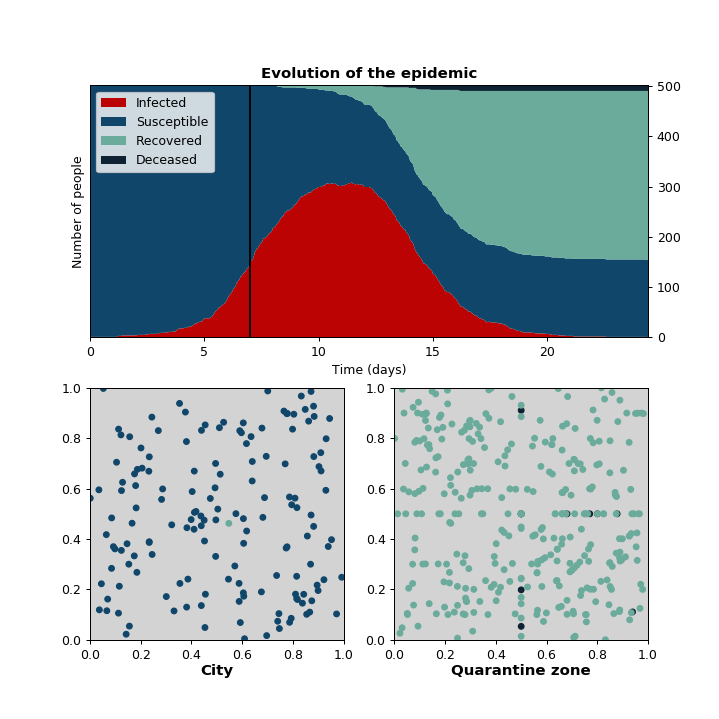

C:\Users\tom_t\Anaconda3\lib\site-packages\ipykernel_launcher.py:276: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


In [3]:
w = World(move=0.1,time_period=1/24.0)
for i in range(500):
    w.add_rand_particle("S")
w.add_rand_particle("I")
w.display()

In [4]:
w.run_perso()